In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
import numpy as np
from astropy.table import QTable
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
ravetable = QTable.read('NEW_rave_tgas_query.csv', format='csv')

In [3]:
print(ravetable)

row_id    ID_TGAS_source        RA_TGAS       ... phot_g_mean_mag_TGAS   HRV  
------ ------------------- ------------------ ... -------------------- -------
     1 5472450241103924224 156.23182631221437 ...      9.8990624156966  17.929
     2 5472934404177638016  155.6757147543367 ...    9.669932745468348   27.33
     3 5472961651450144128 155.67257158269777 ...    9.403665589028403   12.13
     4 5470860587808517120  158.9734503220959 ...   10.119686672861922  38.949
     5 3468060163078890752 184.89737863576525 ...   10.123850113157598  10.372
     6 6158339888161766400 188.61283657498848 ...    9.852586829713339  34.075
     7 6158610402382100096  188.1046316601183 ...    9.620809841126782 -20.148
     8 6158160633407813888 188.96842670922464 ...    9.936459984602394  36.845
     9 6123173658014875136 213.83424541365062 ...   10.767653224679348 -11.692
    10 6123181698193650176 213.84389869951852 ...    9.535751921865415   7.105
   ...                 ...                ... ...   

In [4]:
#Assigning columns in the data table to variable names

pmra = ravetable['pmRA_TGAS']
pmde = ravetable['pmDE_TGAS']
ra = ravetable['RA_TGAS']
dec = ravetable['DE_TGAS']
hrv = ravetable['HRV']
plx = ravetable['parallax_TGAS']
pm = np.sqrt(pmde**2 + (pmra**2) * np.cos(dec)**2)

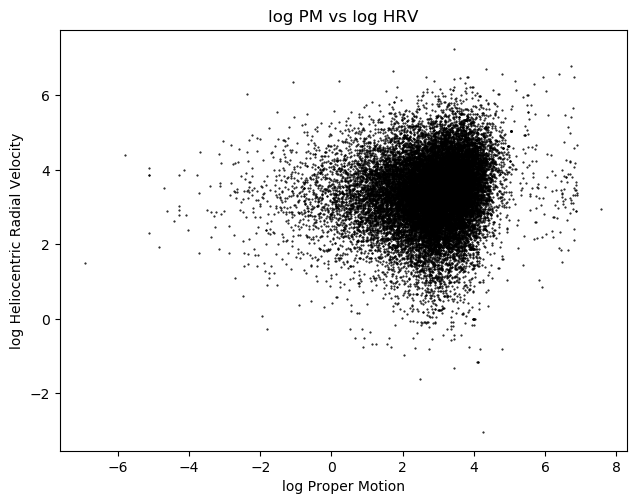

In [5]:
#Plotting data in velocity space

plt.style.use('default')
fig = plt.figure()
ax = fig.add_subplot(111)
 
fig.tight_layout()

ax.set_ylabel("log Heliocentric Radial Velocity")
ax.set_xlabel("log Proper Motion")
ax.set_title("log PM vs log HRV")
    
ax.plot(np.log(hrv), np.log(pm), color='k', marker='.', markersize=1, linestyle='None');

In [6]:
#Adjusting between arcseconds and milliarcseconds

pmra = pmra * 0.001
pmde = pmde * 0.001
plx = plx * 0.001

In [7]:
#Constants for progressing into galactocentric coordinates

rangp = np.radians(192.8583)
decngp = np.radians(27.1280559)
theta0 = np.radians(122.93191857)
k = 4.704057

In [8]:
#Establishing variables for progressing into galactocentric coordinates
#because I was having troubles with matrices and arrays.

a = np.cos(theta0)
b = np.sin(theta0)
c = np.sin(decngp)
d = np.cos(decngp)
e = np.cos(rangp)
f = np.sin(rangp)
g = np.cos(ra)*np.cos(dec)
h = np.sin(ra)
i = np.sin(ra)*np.cos(dec)
j = np.cos(ra)
z = np.sin(ra)*np.sin(dec)
l = np.sin(dec)
m = np.cos(dec)

In [9]:
#Final progressions for galactocentric coordinates.

q = ((-e*a*c - b*f)*g + (-a*c*f + e*b)*i + a*d*l)
r = (j*(-a*c*f + e*b) - h*(-e*a*c - b*f))
s = (-g*(-e*a*c - b*f) - z*(-a*c*f + e*b) + a*d*m)
t = ((-a*f - e*b*c)*g + (-e*a - b*c*f)*i + b*d*l)
u = (j*(-e*a - c*b*f) - h*(a*f - e*b*c))
v = (-g*(a*f - e*c*b) - z*(-e*a - c*b*f) + b*d*m)
w = (e*d*g + d*f*i + c*l)
x = (d*i*f - e*d*h)
y = (-e*d*g - d*z*f + c*m)

ucoord = (q*hrv + r*(k*pmra/plx) + s*(k*pmde/plx))
vcoord = (t*hrv + u*(k*pmra/plx) + v*(k*pmde/plx))
wcoord = (w*hrv + x*(k*pmra/plx) + y*(k*pmde/plx))

#Adding new galactocentric coordinates to columns in the data table.

ravetable['U'] = ucoord
ravetable['V'] = vcoord
ravetable['W'] = wcoord
ucrd = ravetable['U']
vcrd = ravetable['V']
wcrd = ravetable['W']
len(ucrd)

39853

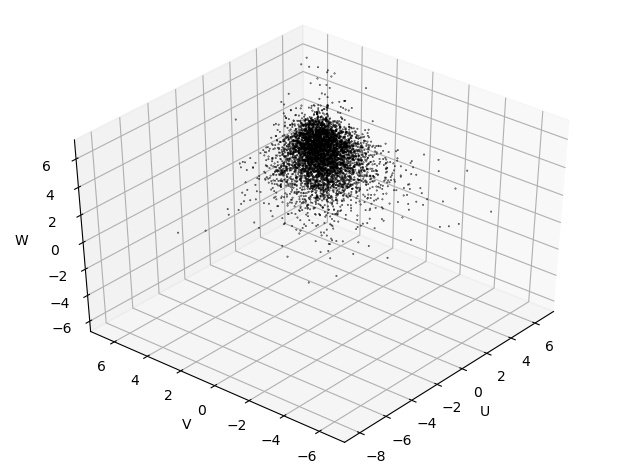

In [10]:
#Plotting new galactocentric coordinates in 3D velocity space.

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_zlabel("W")

ax.scatter(np.log(ucrd), np.log(vcrd), np.log(wcrd), c = 'k', s=0.1, alpha=1);
ax.view_init(azim = -140, elev = 40);

In [11]:
#An interactive version of the above plot
import ipyvolume as ipv
ipv.quickscatter(np.log(ucoord), np.log(vcoord), np.log(wcoord), size=0.5, color="blue")

In [12]:
#Limiting U and V velocities to match Bovy & Hogg, 2009, then zooming in more
#Also limiting W velocities

uvmask = np.where((ucrd < 60) & (ucrd > -60) & (vcrd < 50) & (vcrd > -60) & (wcrd < 60) & (wcrd > -60))

ushort = ucrd[uvmask]
vshort = vcrd[uvmask]
wshort = wcrd[uvmask]
len(ushort)

33518

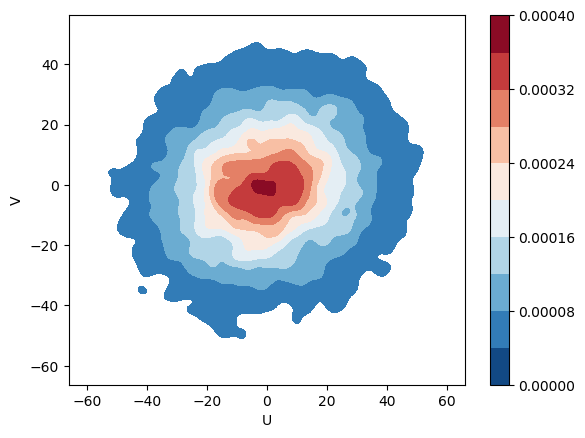

In [13]:
#Kernel density estimate plot of U vs V

sns.kdeplot(ushort, vshort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.show()

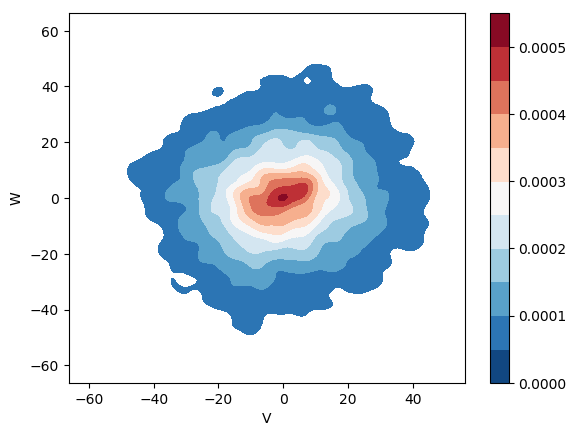

In [14]:
#Kernel density estimate plot of V vs W

sns.kdeplot(vshort, wshort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.show()

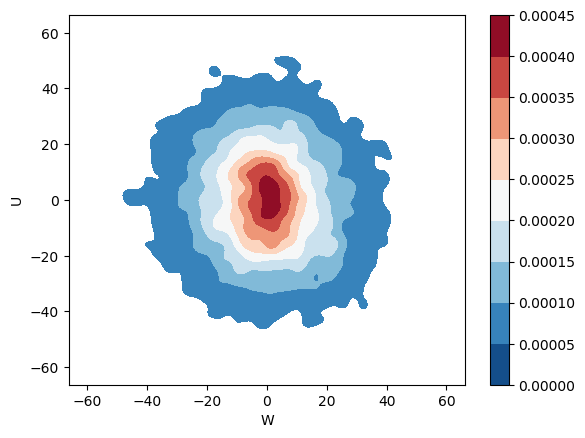

In [15]:
#Kernel density estimate plot of W vs U

sns.kdeplot(wshort, ushort, legend=True, shade=True, gridsize=200, kernel='gau', cbar=True,
            bw=2.1, cmap="RdBu_r", shade_lowest=False)
plt.show()

In [16]:
from sklearn.cluster import KMeans

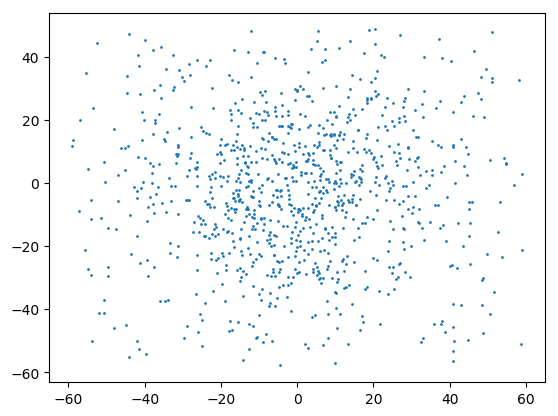

In [17]:
#The beginning of k-means. Clipped dataset from previous plots to be even shorter,
# out of fear of my computer crashing. Plotted simple scatter for comparison.

uveryshort = ushort[1:1000]
vveryshort = vshort[1:1000]
wveryshort = wshort[1:1000]

uveryshort = uveryshort.data
vveryshort = vveryshort.data
wveryshort = wveryshort.data

vsarray = np.array([uveryshort, vveryshort, wveryshort]).T
fullarray = np.vstack((ushort.data,vshort.data)).T

plt.scatter(uveryshort, vveryshort, s=1);

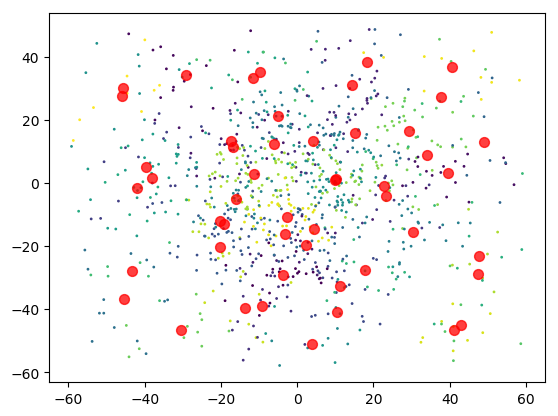

In [18]:
#Initial attempt at applying k-means to the dataset. Not sure if I should 
# be using more or less clusters, or using more or less of the dataset.

kmeans = KMeans(n_clusters=50)
kmeans.fit(vsarray)
y_kmeans = kmeans.predict(vsarray)

plt.scatter(vsarray[:, 0], vsarray[:, 1], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75);

In [19]:
#Converting data columns to objects easier to deal with. Implemented random
# selection of data subsample rows.

udata = ushort.data
vdata = vshort.data
wdata = wshort.data

idx = np.random.choice(np.arange(len(udata)), 3000)
randarray = np.array([udata[idx], vdata[idx], wdata[idx]]).T
print(randarray)

[[-52.62559922  23.26620528  44.09213691]
 [ 16.54795401 -35.74927074 -28.74540379]
 [ 18.61499751   4.78711266  -0.35579252]
 ...
 [ 25.15640068  17.66830442   8.15328864]
 [ -7.3153294  -22.54042092 -36.31493224]
 [ 18.27512065  -3.90474211  -4.55919326]]


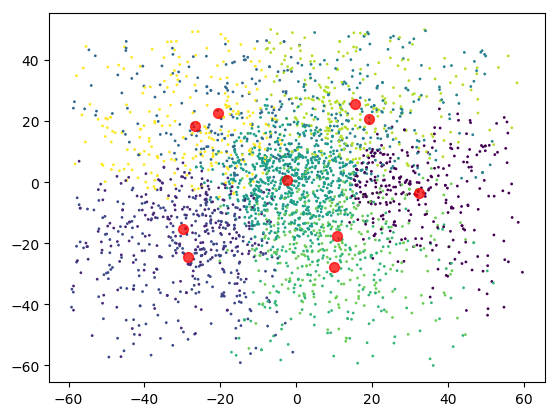

In [20]:
#2D plot of newly implemented random data subsample.

kmeans = KMeans(n_clusters=10)
kmeans.fit(randarray)
y_kmeans = kmeans.predict(randarray)

plt.scatter(randarray[:, 0], randarray[:, 1], c=y_kmeans, s=1, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75);

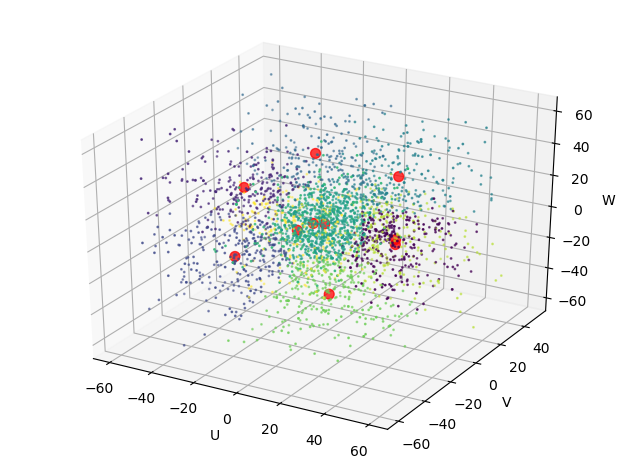

In [22]:
#3D plot of newly implemented random data subsample.

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

fig.tight_layout()

ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_zlabel("W")

ax.scatter(randarray[:, 0], randarray[:, 1], randarray[:, 2], c=y_kmeans, s=1, cmap='viridis');
#ax.view_init(azim = -140, elev = 40);
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', s=50, alpha=0.75);